In [13]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from config import PATH_LOG

CWD = Path.cwd()

In [14]:
experiment = 'farmsall_vit16_23-08-28T10:03:10'
model_name = 'vit16'
task_name = 'farmsall'   # 선택 - PoC:'cifar10', Farmsall:'farmsall'
log_version = 16    # None: next avaiable version
log_path = PATH_LOG / task_name / f'version_{log_version}'

## OOD포함한 일반화된 분류 성능 측정

1. 분류 모델 load

In [15]:
from trainers import ClassificationTask
from models import get_model
from data.common import get_default_transforms
from data.clf_loaders import get_dataset_info

device = 'cuda'
num_workers = 3

ckpt_file = log_path / 'checkpoints' / 'epoch=39-step=204360.ckpt'
dsinfo = get_dataset_info(task_name=task_name)
num_classes = dsinfo['num_classes']

model_instance = get_model(model_name, num_classes=num_classes)
task = ClassificationTask.load_from_checkpoint(ckpt_file,
                                        model=model_instance
                                        # 추가 parameter들이 들어갈 수 있음
                                        )
model = task.model  # the loaded model
model.eval()
model = model.to(device)

input_params = model.input_params
size = input_params['size']
crop_size = input_params['crop_size']
mean = input_params['mean']
std = input_params['std']
transform = get_default_transforms(mean=mean, std=std, crop_size=crop_size, size=size)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/kpark/venv/farms/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


2. OOD detector Load

In [16]:
from collections import Counter
import numpy as np
import torch
from torch import nn
from models.ood import load_detector, set_device


detectors_to_use = ['RMD']  # Ensemble Model?
detectors = [load_detector(log_path / experiment / f'ood_detector_{task_name}_{model_name}_{detector_name}.pkl')
                for detector_name in detectors_to_use]
detectors = [set_device(detector, device) for detector in detectors]


def predict_batch(detectors:list, batch:list, device:str='cpu') -> list:
    preds = []
    with torch.no_grad():
        for detector in detectors:
            scores = detector(batch.to(device))
            preds.append((scores.sigmoid() > detector.threshold).tolist())

    if len(detectors) > 1:  # ensemble
        en_pred = np.array(preds)
        # Voting
        preds = np.apply_along_axis(lambda lt: Counter(lt).most_common(1)[0][0], 0, en_pred).tolist()
    else:
        preds = list(np.concatenate(preds))
        
    return preds


def predict(clf:nn.Module, detectors:list, batch:list, device:str='cpu') -> list:
    preds_ood = predict_batch(detectors, batch, device=device)
    with torch.no_grad():
        logits = model(batch.to(device))
        preds_clf = logits.argmax(-1).cpu()
    idx = np.array(preds_ood) == True
    preds_clf[idx] = -1
    return preds_clf

3. Metric 계산 준비

In [17]:
from torchmetrics import MetricCollection, Accuracy
from torchmetrics import Precision, Recall, F1Score
from torchmetrics import ConfusionMatrix

metric_task = 'multiclass'
num_classes_all = num_classes + 1   # OOD 포함한 class 갯수
metric_train = MetricCollection({'Top@1': Accuracy(task=metric_task, num_classes=num_classes_all, top_k=1)})
metric_train.add_metrics({'Precision': Precision(task=metric_task, num_classes=num_classes_all, average="macro", top_k=1)})
metric_train.add_metrics({'Recall': Recall(task=metric_task, num_classes=num_classes_all, average="macro", top_k=1)})
metric_train.add_metrics({'F1-score': F1Score(task=metric_task, num_classes=num_classes_all, average="macro", top_k=1)})
metric_test = metric_train.clone()
metric_cm_train = ConfusionMatrix(task=metric_task, num_classes=num_classes_all, normalize='none')
metric_cm_test = metric_cm_train.clone()

### Train set에 대한 성능 검증

In [18]:
from tqdm import tqdm
from data.ood_loaders import CropDiseaseOODDataModule


dm = CropDiseaseOODDataModule(transform=transform, num_workers=num_workers, pin_memory=True)
dm.setup('fit')
dm.setup('train')
loader_in_ood = dm.train_dataloader(use_sampler=False)

set_name = 'Train'
for batch_x, batch_y in tqdm(loader_in_ood, f'Loading the DataLoader - {set_name}'):
    preds = predict(model, detectors[0:1], batch_x, device=device)
    preds[preds == -1] = num_classes
    batch_y[batch_y == -1] = num_classes
    metric_train.update(preds, batch_y)
    metric_cm_train.update(preds, batch_y)
    
results_train = metric_train.compute()
cm_train = metric_cm_train.compute()


Files already downloaded and verified
Files already downloaded and verified


Loading the DataLoader - Train: 100%|██████████| 9848/9848 [56:39<00:00,  2.90it/s]


### Test set에 대한 성능 검증

In [19]:
loader_in_ood = dm.test_dataloader()

set_name = 'Test'
for batch_x, batch_y in tqdm(loader_in_ood, f'Loading the DataLoader - {set_name}'):
    preds = predict(model, detectors[0:1], batch_x, device=device)
    preds[preds == -1] = num_classes
    batch_y[batch_y == -1] = num_classes
    metric_test.update(preds, batch_y)
    metric_cm_test.update(preds, batch_y)
    
results_test = metric_test.compute()
cm_test = metric_cm_test.compute()

Loading the DataLoader - Test: 100%|██████████| 1808/1808 [10:26<00:00,  2.89it/s]


In [20]:
results_train = metric_train.compute()
results_test = metric_test.compute()

4. 결과 저장

In [21]:
import json

results_train = {name: value.item() for name, value in results_train.items()}
results_test = {name: value.item() for name, value in results_test.items()}
with (log_path / 'overall_metrics.json').open('w') as fp:
    json.dump({'train': results_train,
                'test': results_test,
                'train_confusion_matrix': cm_train.tolist(),
                'test_confusion_matrix': cm_test.tolist()
                },
                fp, indent=4)
{'train': results_train, 'test': results_test}

{'train': {'Top@1': 0.925857663154602,
  'Precision': 0.9485945105552673,
  'Recall': 0.850200891494751,
  'F1-score': 0.8916500210762024},
 'test': {'Top@1': 0.8793076872825623,
  'Precision': 0.9156854748725891,
  'Recall': 0.8135104179382324,
  'F1-score': 0.8573189973831177}}

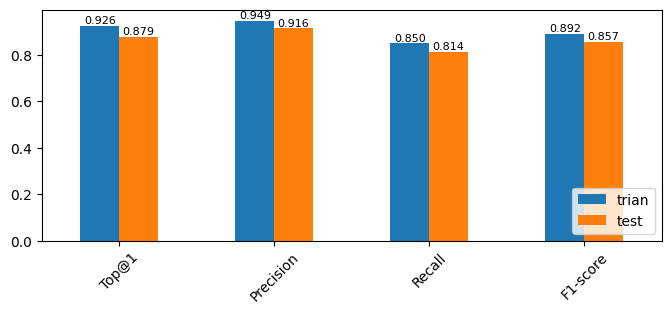

In [22]:
import pandas as pd

metric = pd.concat([pd.DataFrame.from_dict(results_train,  orient='index'),
                    pd.DataFrame.from_dict(results_test,  orient='index')], axis=1)
metric.columns = ['trian', 'test']
axes = metric.plot.bar(rot=45, legend=True, figsize=(8,3))
axes.legend(loc='lower right')
for container in axes.containers:
    axes.bar_label(container, **{'size': 8, 'fmt': '%.3f'})

### 시각화 비교

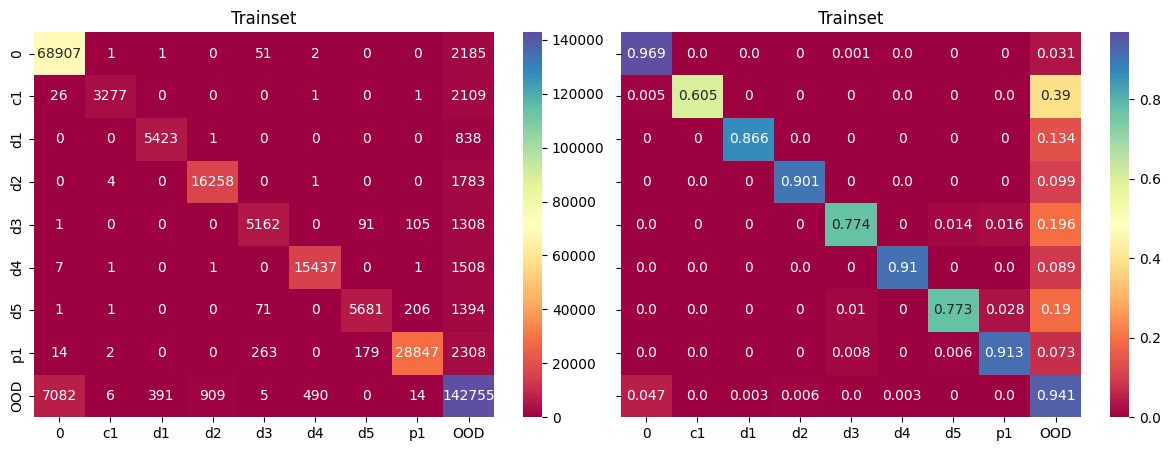

In [23]:
from utils.metric import show_confusion_matrix

classes = dsinfo['classes'] + ['OOD']

fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
plt.subplots_adjust(wspace=0.02)
axes = axes.flatten()
fig = show_confusion_matrix(cm_train.tolist(), ax=axes[0], title='Trainset', classes=classes)
fig = show_confusion_matrix(cm_train.tolist(), ax=axes[1], title='Trainset', classes=classes, normalize=True)

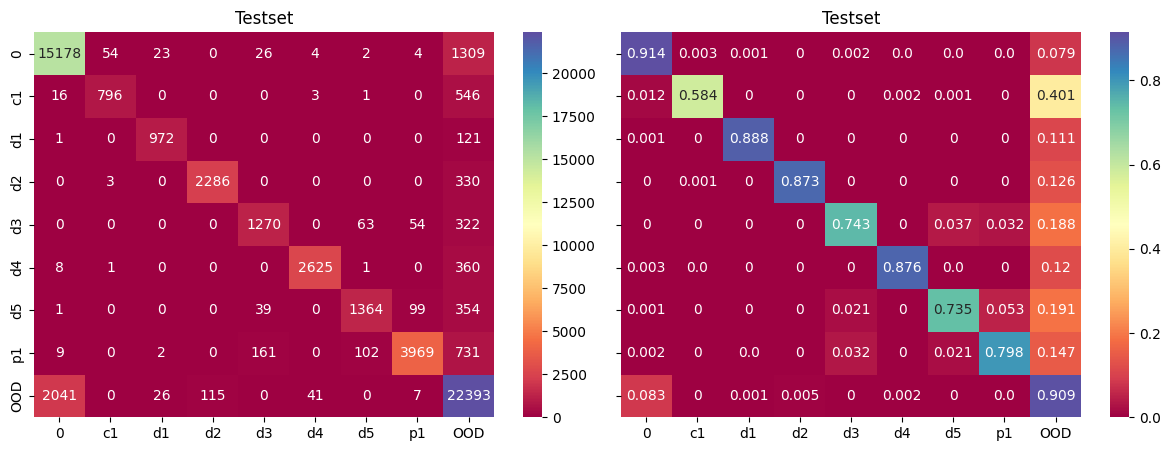

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
plt.subplots_adjust(wspace=0.02)
axes = axes.flatten()
fig = show_confusion_matrix(cm_test.tolist(), ax=axes[0], title='Testset', classes=classes)
fig = show_confusion_matrix(cm_test.tolist(), ax=axes[1], title='Testset', classes=classes, normalize=True)